In [1]:
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas

rng = np.random.default_rng(seed=0)

In [2]:
# Population
SIZE = 150_000
#SIZE = 500_000

BASE_CHURN = 0.16  # 16% churn means 84% retention

# ML
TEST_SIZE = 50_000  # 0.3 # 0.3 means 30% test set size
#TEST_SIZE = 100_000  # 0.3 # 0.3 means 30% test set size

In [3]:
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)


ppl = pd.DataFrame(
    {
        "brand_loyal": rng.binomial(1, 0.25, SIZE),  # True if they just love to renew
        "bad_exp": rng.binomial(
            1, 0.25, SIZE
        ),  # True if they had a bad experience with company
        "mkt_neg": rng.binomial(
            1, 0.25, SIZE
        ),  # True if receiving marketing will increase churn probability for them
        "mkt_pos": rng.binomial(
            1, 0.25, SIZE
        ),  # True if marketing helps retain this customer
    }
)
ppl["gets_mkting"] = rng.binomial(1, 0.5, SIZE)

#ppl["prob_churn"] = BASE_CHURN  # # a reasonably standard churn rate
ppl["prob_churn"] = rng.uniform(BASE_CHURN - 0.02, BASE_CHURN + 0.02, SIZE)
ppl.sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
54966,0,0,1,0,0,0.154759
101952,0,0,0,1,0,0.178158
7465,0,0,0,0,1,0.158318
107387,0,0,0,0,0,0.173701
98476,0,0,0,1,1,0.175129


In [4]:
# people who like marketing and who get marketing have a lower chance of churning
if True:
    mask = (ppl["mkt_pos"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask, "prob_churn"] -= 0.1

    assert (
        mask.sum() / mask.shape[0] < 0.2
    ), "Not expecting a high rate of churn even with random variation"

    display(ppl[mask].sample(5))

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
59642,0,0,1,1,1,0.059441
123306,0,0,0,1,1,0.073608
76453,1,0,0,1,1,0.047809
19495,0,1,0,1,1,0.056015
66390,0,1,0,1,1,0.070216


In [5]:
# people who hate marketing and who get marketing have a higher chance of churning
mask = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
ppl.loc[mask, "prob_churn"] += 0.1  # TODO HUGE BIAS

assert (
    mask.sum() / mask.shape[0] < 0.2
), "Not expecting a high rate of churn even with random variation"

ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
48835,1,0,1,0,1,0.268248
11001,0,0,1,0,1,0.247265
59752,0,0,1,1,1,0.154551
104382,1,1,1,0,1,0.269178
91224,0,0,1,1,1,0.176932


In [6]:
# people who have had a negative experience have a higher chance of churn
mask = ppl["bad_exp"] == 1
ppl.loc[mask, "prob_churn"] += 0.1
ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
19347,0,1,1,1,1,0.242164
138196,0,1,0,0,1,0.243231
85732,1,1,0,0,0,0.247510
65333,0,1,1,0,1,0.346734
125273,0,1,0,1,0,0.245001


In [7]:
# people who like the brand experience have a lower chance of churn
mask = ppl["brand_loyal"] == 1
ppl.loc[mask, "prob_churn"] -= 0.1
ppl[mask].sample(5)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn
85834,1,1,0,0,1,0.175841
145246,1,0,1,1,1,0.060452
93040,1,0,1,0,1,0.149452
132639,1,0,1,1,1,0.050285
11152,1,1,0,0,0,0.143572


In [8]:
ppl["prob_churn"] = ppl["prob_churn"].clip(lower=0, upper=1)

In [9]:
ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])

In [10]:
ppl["prob_churn_bin"] = pd.cut(ppl["prob_churn"], bins=10)
display(ppl.groupby("prob_churn_bin")["will_churn"].sum())
display(
    ppl.groupby("prob_churn_bin")["will_churn"].sum()
    / ppl.groupby("prob_churn_bin")["will_churn"].size()
)
ppl = ppl.drop(columns="prob_churn_bin")

prob_churn_bin
(-0.00038, 0.038]       0
(0.038, 0.076]       1650
(0.076, 0.114]        258
(0.114, 0.152]       3697
(0.152, 0.19]        9499
(0.19, 0.228]           0
(0.228, 0.266]       5284
(0.266, 0.304]       3115
(0.304, 0.342]         43
(0.342, 0.38]         943
Name: will_churn, dtype: int64

prob_churn_bin
(-0.00038, 0.038]    0.000000
(0.038, 0.076]       0.057990
(0.076, 0.114]       0.082192
(0.114, 0.152]       0.150156
(0.152, 0.19]        0.167608
(0.19, 0.228]             NaN
(0.228, 0.266]       0.255933
(0.266, 0.304]       0.280757
(0.304, 0.342]       0.318519
(0.342, 0.38]        0.367498
Name: will_churn, dtype: float64

In [11]:
ppl.head()

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.176941,0
1,0,0,1,1,1,0.141715,0
2,0,0,0,0,0,0.163400,0
3,0,0,0,0,1,0.163549,1
4,1,0,0,0,0,0.068719,0


In [12]:
ppl.describe(percentiles=[0.01, 0.5, 0.99])

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,0.248980,0.249667,0.251393,0.250167,0.500353,0.160811,0.163260
std,0.432424,0.432822,0.433816,0.433110,0.500002,0.074359,0.369604
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.159896,0.000000
99%,1.000000,1.000000,1.000000,1.000000,1.000000,0.357910,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.379996,1.000000


In [13]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.176941,0
1,0,0,1,1,1,0.141715,0
2,0,0,0,0,0,0.163400,0
3,0,0,0,0,1,0.163549,1
4,1,0,0,0,0,0.068719,0
...,...,...,...,...,...,...,...
149995,1,0,0,1,1,0.000000,0
149996,0,0,0,0,0,0.173770,0
149997,0,0,0,0,0,0.159278,0
149998,0,0,0,0,1,0.163058,1


In [14]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(
            int,
            [
                pa.Check.isin([0, 1]),
                pa.Check(lambda s: s.mean() > 0.45),
                pa.Check(lambda s: s.mean() < 0.55),
            ],
        ),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                pa.Hypothesis.two_sample_ttest(
                    sample1=1,
                    sample2=0,
                    groupby="mkt_neg",
                    relationship="greater_than",
                    alpha=0.05,
                    equal_var=True,
                ),
            ],
        ),
    },
    strict=True,
    ordered=False,
)
schema.validate(
    ppl,
    lazy=True,
);

# Look at some examples of those who do or don't churn

In [15]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
3,0,0,0,0,1,0.163549,1
14,0,1,1,0,0,0.256159,1


In [16]:
ppl.query("will_churn==True and prob_churn == @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn


In [17]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
0,0,0,1,0,0,0.176941,0
1,0,0,1,1,1,0.141715,0


# Start to prepare for ML

In [18]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'gets_mkting',
       'prob_churn', 'will_churn'],
      dtype='object')

In [19]:
features = ["mkt_neg", "bad_exp", "mkt_pos", "brand_loyal"]
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = (
    set(ppl.columns)
    .difference(set(features))
    .difference({"will_churn", "prob_churn", "gets_mkting"})
)

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1 / 0  # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [20]:
ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
)
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [21]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.44311442161135384

In [22]:
base_model = LogisticRegression
#base_model = partial(RandomForestClassifier, n_estimators=5)

In [23]:
churn_model = base_model
# churn_model = LogisticRegression
# churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

Fitting churn model with <class 'sklearn.linear_model._logistic.LogisticRegression'>


0.4254150592783153

## Start to prepare for dual fit

In [24]:
# TODO duplication here will hurt and will make debugging much
# harder, this needs simplifying!
# higher logloss is worse
uplift_model = base_model
# uplift_model = LogisticRegression
# uplift_model = partial(RandomForestClassifier, n_estimators=10)
est_up_c = uplift_model()
est_up_t = uplift_model()

print(f"Building a C and T model with {est_up_c} and {est_up_t}")

mask_train_c = ppl_train["gets_mkting"] == 0
mask_train_t = ppl_train["gets_mkting"] == 1

est_up_c.fit(X_train[mask_train_c], y_train[mask_train_c])
est_up_t.fit(X_train[mask_train_t], y_train[mask_train_t])

# score on their sub-trained population type
mask_test_c = ppl_test["gets_mkting"] == 0
mask_test_t = ppl_test["gets_mkting"] == 1
up_c_pred_proba_pos = est_up_c.predict_proba(X_test[mask_test_c])[:, 1]
up_t_pred_proba_pos = est_up_t.predict_proba(X_test[mask_test_t])[:, 1]

print(log_loss(y_test[mask_test_c], up_c_pred_proba_pos))
print(
    log_loss(y_test[mask_test_t], up_t_pred_proba_pos)
)  # CHECK expect lower than control

Building a C and T model with LogisticRegression() and LogisticRegression()
0.4244101846559934
0.4180884180101082


## Check C and T predictions from Uplift model

In [25]:
pd.Series(up_c_pred_proba_pos).describe()

count    25030.000000
mean         0.163935
std          0.063423
min          0.071965
25%          0.155737
50%          0.159432
75%          0.160625
max          0.280636
dtype: float64

In [26]:
pd.Series(up_t_pred_proba_pos).describe()

count    24970.000000
mean         0.163339
std          0.088072
min          0.032206
25%          0.073433
50%          0.154463
75%          0.241585
max          0.423380
dtype: float64

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [27]:
if False:
    # incorrect for uplift! # WRONG
    result = pd.DataFrame({"churn_proba_pos": y_pred_proba_pos, "y_true": y_test})
    result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]

    result["uplift_proba_pos"] = -1
    result.loc[mask_test_t, "uplift_proba_pos"] = up_t_pred_proba_pos
    result.loc[mask_test_c, "uplift_proba_pos"] = up_c_pred_proba_pos
    assert (result["uplift_proba_pos"] == -1).sum() == 0, "No entries for -1 expected"

    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
    keys = ["uplift_proba_pos", "churn_proba_pos", "dummy_proba_pos"]
    for key in keys:
        result_sorted = result.sort_values(key, ascending=False).reset_index()
        result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
        result_sorted.plot(kind="line", y="y_true_cum", ax=ax, label=key)
    ax.set_ylabel("True Positives (faster climb better)")
    ax.set_xlabel("Test population")

    set_common_mpl_styles(ax, grid_axis="both")
    # set_commas(ax, True, True)

    # ax.set_xlim((10_000, result.shape[0]-1)); # zoom on x axis

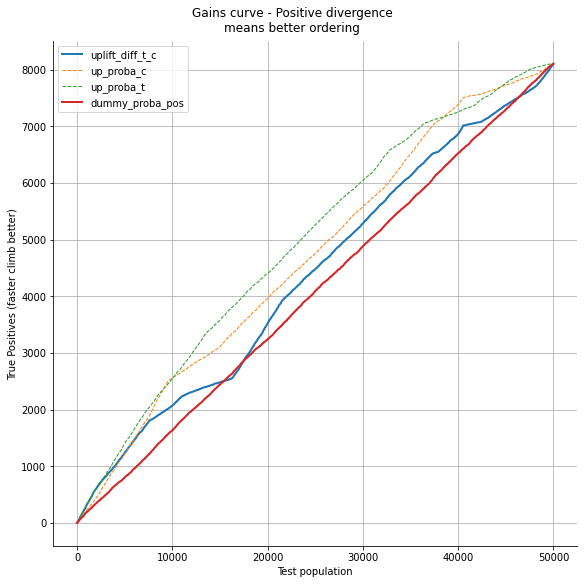

In [28]:
# incorrect for uplift!
result = pd.DataFrame({"y_true": y_test})

result["churn_proba_pos"] = est_churn.predict_proba(X_test)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_test)[:, 1]


result["up_proba_c"] = est_up_c.predict_proba(X_test)[:, 1]
result["up_proba_t"] = est_up_t.predict_proba(X_test)[:, 1]
# if T says 90% prob churn conditional mkting, C says 10% prob churn then +80%
# if T says 10% prob churn conditional mkting, C says 90% prob churn then -80%
result["uplift_diff_t_c"] = result["up_proba_t"] - result["up_proba_c"]

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
# key = 'uplift_diff_t_c'
# keys = ['uplift_diff_t_c', 'churn_proba_pos', 'dummy_proba_pos']
keys = [#"churn_proba_pos",
    "uplift_diff_t_c",
    "up_proba_c",
    "up_proba_t",
    "dummy_proba_pos", 
]  # , 'churn_proba_pos']
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1
    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Test population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

<AxesSubplot:>

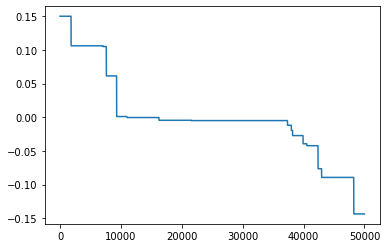

In [29]:
# sort by predicted uplift, the earliest values have lowest chance of churn if marketed at or are sure things,
# the last values have highest chance of churn if marketed at (sleeping dogs) or are lost causes
result.sort_values("uplift_diff_t_c", ascending=False)["uplift_diff_t_c"].reset_index(
    drop=True
).plot()

In [30]:
test_merged = pd.merge(
    left=result,
    right=ppl_test,
    left_index=True,
    right_index=True,
    validate="one_to_one",
)
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values("prob_churn").drop(
    columns=["dummy_proba_pos", "churn_proba_pos"]
)

,y_true,up_proba_c,up_proba_t,uplift_diff_t_c,brand_loyal,bad_exp,mkt_neg,mkt_pos,gets_mkting,prob_churn,will_churn
117143,0,0.160625,0.071242,-0.089384,0,0,0,1,1,0.071143,0
19944,0,0.073847,0.073433,-0.000414,1,0,0,0,1,0.073940,0
91477,0,0.074456,0.032206,-0.042250,1,0,0,1,0,0.075188,0
37476,0,0.071965,0.133397,0.061431,1,0,1,0,1,0.142982,0
110118,1,0.159432,0.154463,-0.004969,0,0,0,0,0,0.157011,1
132743,0,0.160625,0.071242,-0.089384,0,0,0,1,0,0.157085,0
61678,0,0.160625,0.071242,-0.089384,0,0,0,1,0,0.159901,0
15224,0,0.159432,0.154463,-0.004969,0,0,0,0,0,0.176175,0
85373,0,0.278848,0.274329,-0.004519,0,1,0,0,1,0.244523,0
31286,0,0.136507,0.241585,0.105079,1,1,1,0,1,0.256617,0


In [31]:
test_merged["uplift_diff_t_c_bins"] = pd.cut(test_merged["uplift_diff_t_c"], 3)
test_merged["churn_proba_pos_bins"] = pd.cut(test_merged["churn_proba_pos"], 3)

#test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 4)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

In [32]:
res = test_merged.groupby("uplift_diff_t_c_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
)
#res

# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [33]:
def make_pretty(styler, title):
    styler.set_caption(title)
    # styler.format(rain_condition)
    # styler.format_index(lambda v: v.strftime("%A"))
    # styler.background_gradient(axis='columns', vmin=1, vmax=5, cmap="YlGnBu")
    styler.background_gradient(axis="rows", cmap="YlGnBu")
    return styler


display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
res.style.pipe(make_pretty, "Feature contributions to Uplift prediction")

'Base churn rate for all is circa 16.0%'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum,up_proba_c_mean,up_proba_t_mean
uplift_diff_t_c_bins,,,,,,,,
"(-0.144, -0.0457]",7628,0.134898,7628,2345,586,0,0.186784,0.085880
"(-0.0457, 0.0522]",33085,0.153786,5016,7831,9636,3176,0.159486,0.151527
"(0.0522, 0.15]",9287,0.213955,0,2375,2260,9287,0.162170,0.268660


In [34]:
res = test_merged.groupby("churn_proba_pos_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
    #up_proba_c_mean=pd.NamedAgg("up_proba_c", "mean"),
    #up_proba_t_mean=pd.NamedAgg("up_proba_t", "mean"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
res.style.pipe(make_pretty, "Feature contributions to Churn prediction")

'Base churn rate for all is circa 16.0%'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
churn_proba_pos_bins,,,,,,
"(0.0515, 0.15]",17197,0.088155,8547,2491,11914,2530
"(0.15, 0.249]",25070,0.178740,3479,2327,568,7508
"(0.249, 0.347]",7733,0.272469,618,7733,0,2425


# Estimate value to business by using Uplift over Churn

**caveat** this assume we know who we will and won't market to - but that's goverened by the earlier simulation! This needs to be **figured out**

In [48]:
RETENTION_VALUE = 100
MARKETING_VALUE = -100 # negative means a cost

test_merged_value = test_merged.copy()

test_merged_value['cust_value'] = test_merged_value['gets_mkting'] * MARKETING_VALUE + (1-test_merged_value['will_churn']) * RETENTION_VALUE
churn_cum_sum = test_merged_value.sort_values('churn_proba_pos', ascending=False)['cust_value'].cumsum().reset_index(drop=True)
#churn_cum_sum.plot()

In [49]:
uplift_cum_sum = test_merged_value.sort_values('uplift_diff_t_c', ascending=False)['cust_value'].cumsum().reset_index(drop=True)

<AxesSubplot:>

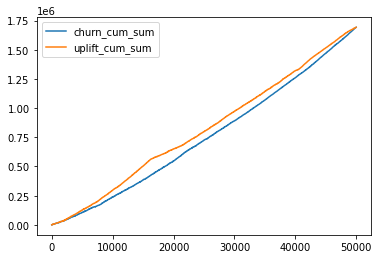

In [50]:
pd.DataFrame({'churn_cum_sum': churn_cum_sum, 'uplift_cum_sum': uplift_cum_sum}).plot()